In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from sampling_utils.metrics import ESS, acl_spectrum
from sampling_utils.total_variation import (
    average_total_variation,
)

In [3]:
def log_target_dens(x):
    """
    returns the value of a target density - standard d-dimensional gaussian
    """
    return -np.sum(x**2)/2

def grad_target_dens(x):
    """
    returns the gradient of log-density 
    """
    return -x

def logp_mala(y,z,gamma):
    return -1/(4*gamma)*(np.sum((y - z - gamma*grad_target_dens(z))**2))

def discretesampling(w):
    u = np.random.rand()
    bins = np.cumsum(w)
    return np.digitize(u,bins)

def log_dens_isir(x,sigma):
    """
    compute log-density of a normal distribution with standard deviation sigma**2
    """
    return -np.sum(x**2)/(2*sigma**2)

In [4]:
def mala(x0,gamma,n,d):
    """
    function to perform n times MALA step 
    """
    #generate proposals
    x_cur = x0
    for i in range(n):
        y = x_cur + gamma*grad_target_dens(x_cur) + np.sqrt(2*gamma)*np.random.randn(d)
        #compute accept-reject
        log_prob_accept = np.minimum(0.0, log_target_dens(y) + logp_mala(x_cur,y,gamma) - log_target_dens(x_cur) - logp_mala(y,x_cur,gamma))
        #generate uniform distribution
        unif = np.log(np.random.uniform())
        indic_acc = (log_prob_accept > unif)
        global n_accepts
        n_accepts += indic_acc
        x_cur = indic_acc*y + (1-indic_acc)*x_cur
    return x_cur

In [5]:
def i_sir(x0,N,sigma_isir,d):
    """
    function to sample with N-particles version of i-SIR
    args:
        N_part - number of particles, integer;
        x0 - current i-sir particle;
    return:
        x_next - selected i-sir particle
    """
    #generate proposals
    proposals = sigma_isir*np.random.randn(N,d)
    #put current particles
    proposals[0,:] = x0
    #compute importance weights
    logw = np.zeros(N,dtype=float)
    for i in range(N):
        logw[i] = log_target_dens(proposals[i,:]) - log_dens_isir(proposals[i,:],sigma_isir)
    maxLogW = np.max(logw)
    uw = np.exp(logw-maxLogW)
    w = uw / np.sum(uw)
    #sample selected index
    idx = discretesampling(w)
    global n_accepts_isir
    if idx != 0:
        n_accepts_isir += 1
    #retur seleted particle
    return proposals[idx]

In [6]:
def ex2_mcmc(x0,N,sigma_isir,gamma,n_steps_mala,d):
    """
    function to sample with N-particles vrsion of i-SIR using MALA as a rejuvenation kernel with step size gamma
    """
    #generate proposals
    proposals = sigma_isir*np.random.randn(N,d)
    #put current particles
    proposals[0,:] = x0
    #compute importance weights
    logw = np.zeros(N,dtype=float)
    for i in range(N):
        logw[i] = log_target_dens(proposals[i,:]) - log_dens_isir(proposals[i,:],sigma_isir)
    maxLogW = np.max(logw)
    uw = np.exp(logw-maxLogW)
    w = uw / np.sum(uw)
    #sample selected index
    idx = discretesampling(w)
    #return seleted particle
    x_new = proposals[idx]
    global n_accepts_isir
    if idx != 0:
        n_accepts_isir += 1
    #perform rejuvenation step
    x_rej = mala(x_new,gamma,n_steps_mala,d)
    return x_rej

### Put parameters of the target density

In [11]:
dims = [30,60,90,120,150,180,210,240,270,300]
import copy

In [12]:
N_samples = 1000
N_particles = 200
gamma = 0.2
N_steps_mala = 5
sigma_isir = np.sqrt(2.0)
n_accepts_isir = 0
n_accepts = 0
isir_res = []
ex2_res = []
gt_samples = []
n_replications = 100
### sample i-sir

for j in range(n_replications):
    isir_res_cur = []
    ex2_res_cur =[]
    for d in dims:
        np.random.seed(42+j)
        gt_samples.append(np.random.randn(N_samples,d))
        x0 = sigma_isir*np.random.randn(d)
        x_cur = x0
        Samples_isir = np.zeros((N_samples,d),dtype = float)
        for i in range(N_samples):
            x_cur = i_sir(x_cur,N_particles,sigma_isir,d)
            Samples_isir[i] = x_cur
        isir_res_cur.append(copy.deepcopy(Samples_isir))
        #sample with ex2
        Samples_ex2 = np.zeros((N_samples,d),dtype = float)
        x_cur = x0
        for i in range(N_samples):
            x_cur = ex2_mcmc(x_cur,N_particles,sigma_isir,gamma,N_steps_mala,d)
            Samples_ex2[i] = x_cur
        ex2_res_cur.append(copy.deepcopy(Samples_ex2))
    isir_res.append(copy.deepcopy(isir_res_cur))
    ex2_res.append(copy.deepcopy(ex2_res_cur))

In [13]:
#compute OT distance
emd_isir = []
emd_ex2 =[]
ess_isir = []
ess_ex2 = []
mean_isir = []
mean_ex2 = []
for j in range(n_replications):
    emd_isir_cur = []
    emd_ex2_cur = []
    ess_isir_cur = []
    ess_ex2_cur = []
    mean_isir_cur = []
    mean_ex2_cur = []
    for i in range(len(dims)):
        d = dims[i]
        Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
        Cost_matr_ex2 = ot.dist(x1 = ex2_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
        emd_isir_cur.append(ot.lp.emd2([], [], Cost_matr_isir))
        emd_ex2_cur.append(ot.lp.emd2([], [], Cost_matr_ex2))
        mean_isir_cur.append(isir_res[j][i].mean(0)[0])
        mean_ex2_cur.append(ex2_res[j][i].mean(0)[0])
        ess_isir_cur.append(ESS(
            acl_spectrum(
                isir_res[j][i] - isir_res[j][i].mean(0),
            ),
        ).mean())
        ess_ex2_cur.append(ESS(
            acl_spectrum(
                ex2_res[j][i] - ex2_res[j][i].mean(0),
            ),
        ).mean())
    emd_isir.append(np.asarray(emd_isir_cur))
    emd_ex2.append(np.asarray(emd_ex2_cur))
    ess_isir.append(np.asarray(ess_isir_cur))
    ess_ex2.append(np.asarray(ess_ex2_cur))
    mean_isir.append(np.asarray(mean_isir_cur))
    mean_ex2.append(np.asarray(mean_ex2_cur))
        
emd_isir = np.asarray(emd_isir)
emd_ex2 = np.asarray(emd_ex2)

ess_isir = np.asarray(ess_isir)
ess_ex2 = np.asarray(ess_ex2)

mean_isir = np.asarray(mean_isir)
mean_ex2 = np.asarray(mean_ex2)

In [17]:
print(emd_isir.shape)
print(ess_isir.shape)
print(mean_isir.shape)
mean_isir = np.asarray(mean_isir)
mean_ex2 = np.asarray(mean_ex2)

(50, 10)
(50, 10)
(50, 10)


In [19]:
ess_isir[8,-2] = 0.0
ess_isir

array([[0.38860147, 0.12571357, 0.02814324, 0.01333458, 0.00685   ,
        0.01817991, 0.01141086, 0.01403981, 0.01113144, 0.01289384],
       [0.40263176, 0.12529843, 0.04169524, 0.02711106, 0.01339128,
        0.00989312, 0.01565529, 0.00840861, 0.0212632 , 0.01432617],
       [0.3927468 , 0.04728964, 0.02077062, 0.04016702, 0.01163793,
        0.00755348, 0.00738548, 0.0113167 , 0.01301121, 0.01003612],
       [0.40644953, 0.04363246, 0.03121069, 0.02750295, 0.01213111,
        0.01164597, 0.01736744, 0.00911968, 0.0121132 , 0.01180108],
       [0.41732345, 0.07123972, 0.05015678, 0.02091764, 0.0185917 ,
        0.01049541, 0.01008667, 0.01028838, 0.01442069, 0.00955379],
       [0.40945444, 0.04923817, 0.03589113, 0.01446446, 0.01614597,
        0.01082878, 0.00904842, 0.01140343, 0.01077085, 0.01218576],
       [0.38424934, 0.05476174, 0.01233091, 0.01563922, 0.01387436,
        0.01440409, 0.01429764, 0.0089516 , 0.03513471, 0.01264248],
       [0.37991755, 0.05025655, 0.0258717

In [15]:
np.amin(mean_ex2,axis=0)
major_xticks = [60,120,180,240,300]

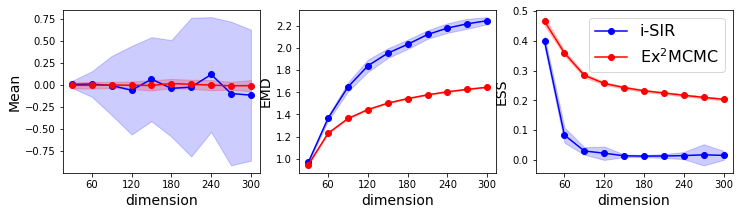

In [20]:
fig,ax = plt.subplots(1,3,figsize=(12,3))
#i-sir plots
ax[0].plot(dims,mean_isir.mean(axis=0),marker="o",c='b',label="i-SIR")
ax[0].plot(dims,mean_ex2.mean(axis=0),marker="o",c='r',label="Ex$^2$-MCMC")
ax[0].fill_between(
            dims,
            mean_isir.mean(axis=0) - mean_isir.std(axis=0),
            mean_isir.mean(axis=0) + mean_isir.std(axis=0),
            alpha=0.2,
            color = 'b'
        )
ax[0].fill_between(
            dims,
            mean_ex2.mean(axis=0) - mean_ex2.std(axis=0),
            mean_ex2.mean(axis=0) + mean_ex2.std(axis=0),
            alpha=0.2,
            color = 'r'
        )
#ax[0].set_title('Mean confidence intervals')
#ax[0].set_xticks(dims,fontsize=14)
ax[0].set_xlabel('dimension',fontsize=14)
ax[0].set_xticks(major_xticks)
ax[0].set_ylabel('Mean',fontsize=14)
#mala samples
ax[1].plot(dims,emd_isir.mean(axis=0)/dims,marker="o",c='b',label="i-SIR")
ax[1].plot(dims,emd_ex2.mean(axis=0)/dims,marker="o",c='r',label="Ex$^2$-MCMC")
ax[1].fill_between(
            dims,
            emd_isir.mean(axis=0)/dims - emd_isir.std(axis=0)/dims,
            emd_isir.mean(axis=0)/dims + emd_isir.std(axis=0)/dims,
            alpha=0.2,
            color = 'b'
        )
ax[1].fill_between(
            dims,
            emd_ex2.mean(axis=0)/dims - emd_ex2.std(axis=0)/dims,
            emd_ex2.mean(axis=0)/dims + emd_ex2.std(axis=0)/dims,
            alpha=0.2,
            color = 'r'
        )
#ax[1].set_title('EMD distance')
#ax[1].set_xticks(dims,fontsize=14)
ax[1].set_xticks(major_xticks)
ax[1].set_xlabel('dimension',fontsize=14)
ax[1].set_ylabel('EMD',fontsize=14)
#ex2-mcmc samples
ax[2].plot(dims,ess_isir.mean(axis=0),marker="o",c='b',label="i-SIR")
ax[2].plot(dims,ess_ex2.mean(axis=0),marker="o",c='r',label="Ex$^2$MCMC")
ax[2].fill_between(
            dims,
            ess_isir.mean(axis=0) - ess_isir.std(axis=0),
            ess_isir.mean(axis=0) + ess_isir.std(axis=0),
            alpha=0.2,
            color = 'b'
        )
ax[2].fill_between(
            dims,
            ess_ex2.mean(axis=0) - ess_ex2.std(axis=0),
            ess_ex2.mean(axis=0) + ess_ex2.std(axis=0),
            alpha=0.2,
            color = 'r'
        )
#ax[2].set_title('EMD')
#ax[2].set_xticks(dims,fontsize=14)
ax[2].set_xticks(major_xticks)
ax[2].set_xlabel('dimension',fontsize=14)
ax[2].set_ylabel('ESS',fontsize=14)
ax[2].legend(fontsize = 16)
plt.savefig("multidim_gaus_example.pdf", format="pdf", bbox_inches="tight") 
plt.show()